[RBF网络原帖](https://zhuanlan.zhihu.com/p/159199147#:~:text=RBF%EF%BC%88Radial%20Basis,Function%2C%20%E5%BE%84%E5%90%91%E5%9F%BA%E5%87%BD%E6%95%B0%EF%BC%89%E7%BD%91%E7%BB%9C%E4%B8%80%E8%88%AC%E6%9D%A5%E8%AF%B4%EF%BC%8C%E6%98%AF%E4%B8%80%E7%A7%8D%E5%8D%95%E9%9A%90%E5%B1%82%E5%89%8D%E9%A6%88%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%EF%BC%8C%E5%AE%83%E4%BD%BF%E7%94%A8%E5%BE%84%E5%90%91%E5%9F%BA%E5%87%BD%E6%95%B0%E4%BD%9C%E4%B8%BA%E9%9A%90%E5%90%AB%E5%B1%82%E7%A5%9E%E7%BB%8F%E5%85%83%E6%BF%80%E6%B4%BB%E5%87%BD%E6%95%B0%EF%BC%8C%E8%80%8C%E8%BE%93%E5%87%BA%E5%B1%82%E5%88%99%E6%98%AF%E5%AF%B9%E9%9A%90%E5%90%AB%E5%B1%82%E7%A5%9E%E7%BB%8F%E5%85%83%E8%BE%93%E5%87%BA%E7%9A%84%E7%BA%BF%E6%80%A7%E7%BB%84%E5%90%88%E3%80%82)



一、基础概念：

RBF（Radial Basis Function, 径向基函数）网络。一般来说，是一种单隐层前馈神经网
络，它使用径向基函数作为隐含层神经元激活函数，最常见径向基函数是高斯径向基函数，也叫高斯核函数或者是RBF核函数。这种操作与非线性SVM很相似。输出层则是对隐含层神经元输出的线性组合。

二、与经典BP区别与联系

一般来说RBF的速度会快于BP，它没有多层网络，而是将特征映射到高维空间，便于区别。

课本图5.7的BP网络输出及隐藏层都是神经元模型（有激活函数）。可把RBF理解为隐藏层仅有一个，激活函数为径向基函数，输出层激活函数是1的BP神经网络。



RBF网络的拓扑结构如下图：




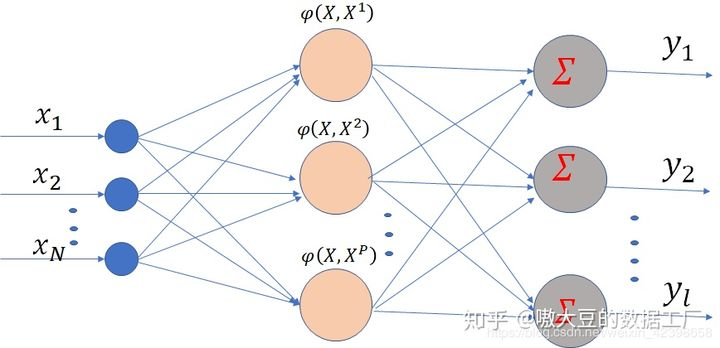

二、功能及Python实现

本次实现的是RBF解决回归问题，所以在输出层的激活函数设置为恒等函数，要是想实现分类问题，理论上可以将输出层的激活函数设置为sigmoid或者relu等函数。

首先，构造一个RBF网络类。

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os

class RBFnetwork(object):
    def __init__(self, hidden_nums, r_w, r_c, r_sigma):
        self.h = hidden_nums        #隐含层神经元个数
        self.w = 0                  #线性权值
        self.c = 0                  #神经元中心点
        self.sigma = 0              #高斯核宽度
        self.r = {"w":r_w, 
                  "c":r_c, 
                  "sigma":r_sigma}  #参数迭代的学习率
        self.errList = []           #误差列表
        self.n_iters = 0            #实际迭代次数
        self.tol = 1.0e-5           #最大容忍误差
        self.X = 0                  #训练集特征
        self.y = 0                  #训练集结果
        self.n_samples = 0          #训练集样本数量
        self.n_features = 0         #训练集特征数量

    # 其次，写下函数的主体部分，因为是单隐层，所以将前向计算和反向传播误差都统一写在train函数中。
    #训练
    def train(self, X, y, iters):
        self.X = X
        self.y = y.reshape(-1,1)
        self.n_samples, self.n_features = X.shape
        sigma, c, w = self.init()                           #初始化参数
        for i in range(iters):
            ##正向计算过程
            hi_output = self.change(sigma,X,c)              #隐含层输出(m,h)，即通过径向基函数的转换
            yi_input = self.addIntercept(hi_output)         #输出层输入(m,h+1)，因为是线性加权，故将偏置加入
            yi_output = np.dot(yi_input, w)                 #输出预测值(m,1)
            error = self.calSSE(yi_output, y)               #计算误差
            if error < self.tol:
                break
            self.errList.append(error)                      #保存误差
            ##误差反向传播过程
            deltaw = np.dot(yi_input.T, (yi_output-y))      #(h+1,m)x(m,1)
            w -= self.r['w']*deltaw/self.n_samples
            deltasigma = np.divide(np.multiply(np.dot(np.multiply(hi_output,self.l2(X,c)).T, \
                        (yi_output-y)), w[:-1]), sigma**3)  #(h,m)x(m,1)
            sigma -= self.r['sigma']*deltasigma/self.n_samples
            deltac1 = np.divide(w[:-1],sigma**2)            #(h,1)
            deltac2 = np.zeros((1,self.n_features))                       #(1,n)
            for j in range(self.n_samples):
                deltac2 += (yi_output-y)[j]*np.dot(hi_output[j], X[j]-c)
            deltac = np.dot(deltac1,deltac2)                #(h,1)x(1,n)
            c -= self.r['c']*deltac/self.n_samples
        self.c = c
        self.w = w
        self.sigma = sigma
        self.n_iters = i

    # 然后，是训练过程中用到的一些函数。
    #计算径向基距离函数
    def guass(self, sigma, X, ci):
        return np.exp(-np.linalg.norm((X-ci), axis=1)**2/(2*sigma**2))

    #将原数据高斯转化成新数据
    def change(self, sigma, X, c):
        newX = np.zeros((self.n_samples, len(c)))
        for i in range(len(c)):
            newX[:,i] = self.guass(sigma[i], X, c[i])
        return newX

    #初始化参数
    def init(self):
        sigma = np.random.random((self.h, 1))               #(h,1)
        c = np.random.random((self.h, self.n_features))     #(h,n)
        w = np.random.random((self.h+1, 1))                 #(h+1,1)
        return sigma, c, w

    #给输出层的输入加一列截距项
    def addIntercept(self, X):
        return np.hstack((X,np.ones((self.n_samples,1))))

    #计算整体误差
    def calSSE(self, prey, y):
        return 0.5*(np.linalg.norm(prey - y))**2

    #求L2范数的平方
    def l2(self, X, c):
        m,n = np.shape(X)
        newX = np.zeros((m, len(c)))
        for i in range(len(c)):
            newX[:,i] = np.linalg.norm((X-c[i]), axis=1)**2
        return newX
        
    # 最后，当然也少不了预测函数。
    #预测
    def predict(self, X):
        hi_output = self.change(self.sigma,X,self.c)    #隐含层输出(m,h)，即通过径向基函数的转换
        yi_input = self.addIntercept(hi_output)         #输出层输入(m,h+1)，因为是线性加权，故将偏置加入
        yi_output = np.dot(yi_input, self.w)            #输出预测值(m,1)
        return yi_output

因为实现的是回归问题，所以我们用写好的代码来测试下函数拟合问题。在这里我们需要拟合的是Hermit多项式，如下图所示：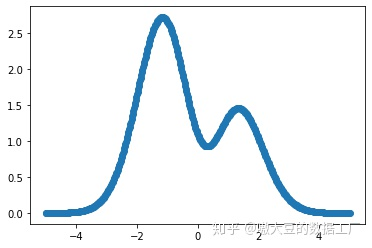

总体误差为： 0.10237962453923866


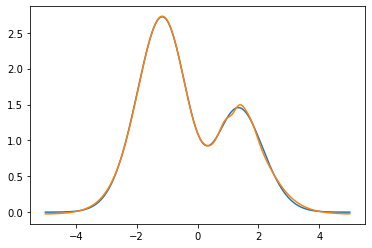

In [41]:
if __name__ == "__main__":
    #拟合Hermit多项式
    X = np.linspace(-5, 5 , 500)[:, np.newaxis]
    y = np.multiply(1.1*(1-X+2*X**2),np.exp(-0.5*X**2))
    rbf = RBFnetwork(50, 0.1, 0.2, 0.1)
    #手动更改迭代次数比较区别
    rbf.train(X, y, 2000)

    #原码没有以下代码，为直观表达特此添加
    z = rbf.predict(X)
    error = rbf.calSSE(z,y)
    print("总体误差为：",error)
    plt.plot(X,y)
    plt.plot(X,z)
    plt.show()